In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mtcnn
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_applications

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 41.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-8amzcme1
  Running command git clone --filter=blob:none --quiet https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-8amzcme1
  Resolved https://github.com/rcmalli/keras-vggface.git to commit bee35376e76e35d00aeec503f2f242611a97b38a
  Preparing metadata (setup.py) ... done
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8298 sha256=359efadb337e4adb3613dc6818e2acd9661532d0aed0c6ecec95087499db25c5
  Stored in directory: /tmp/pip-ephem-wheel-cache-z_8wp_63/wheels/62/cd/e0/3a2d2fe84d014324aed54d420cab52df65a774d9b296c63996
Successfully built keras-vggface
ERROR: Operation cancelled by user
Lookin

#Detect Face

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 # opencv
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image


In [ ]:
detector = MTCNN()

1/1 [==============================] - 0s 205ms/step


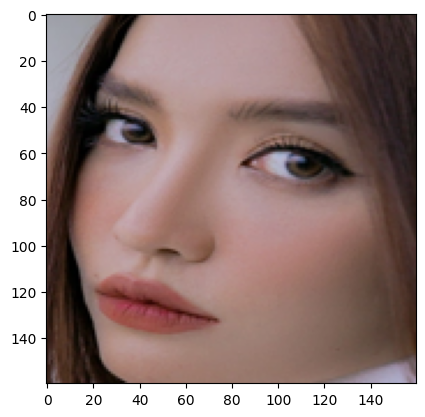

(160, 160, 3)


In [ ]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    if results:
      x1, y1, width, height = results[0]['box']
      # deal with negative pixel index
      x1, y1 = abs(x1), abs(y1)
      x2, y2 = x1 + width, y1 + height
      # extract the face
      face = pixels[y1:y2, x1:x2]
      # resize pixels to the model size
      image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

# load the photo and extract the face
pixels = extract_face('/content/drive/MyDrive/artist_recognition/data_artist/bichphuong/1-1591202621945779611765.jpg')
plt.imshow(pixels)
plt.show()
print(pixels.shape)

In [ ]:
import os
def load_face(dir):
    faces = list()
    # enumerate files
    for filename in os.listdir(dir):
        path = dir + filename
        face = extract_face(path)
        faces.append(face)
    return faces

def load_dataset(dir):
    # list for faces and labels
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + subdir + '/'
        faces = load_face(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir) ) # print progress
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)


# load train dataset
trainX, trainy = load_dataset('/content/drive/MyDrive/artist_recognition/dataset/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('/content/drive/MyDrive/artist_recognition/dataset/')
print(testX.shape, testy.shape)

# save and compress the dataset for further use
np.savez_compressed('9-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

In [ ]:
data = np.load('/content/drive/MyDrive/artist_recog/artist_recognition/9-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (340, 160, 160, 3) (340,) (340, 160, 160, 3) (340,)


In [ ]:
!pip install keras_facenet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for keras_facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10370 sha256=6b4095e68eff4a758eacd356ab3513fd3c2b10e9fdd1949450de13e8fe2def5a
  Stored in directory: /root/.cache/pip/wheels/1d/d8/a9/85cf04ea29321d2afcb82c0caaafdca9195385f9d68cbc7185
Successfully built keras_facenet


In [ ]:
# load the facenet model
from keras_facenet import FaceNet
facenet_model = FaceNet()
print('Loaded Model')

Loaded Model


In [ ]:
def get_embedding(model, face):
    # scale pixel values
    face = face.astype('float32')
    # standardization
    #mean, std = face.mean(), face.std()
    #face = (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    # make prediction to get embedding
    yhat = model.embeddings(sample)
    return yhat[0]

# convert each face in the train set into embedding
emdTrainX = list()
for face in trainX:
    emd = get_embedding(facenet_model, face)
    emdTrainX.append(emd)

emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)

# convert each face in the test set into embedding
emdTestX = list()
for face in testX:
    emd = get_embedding(facenet_model, face)
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)
print(emdTestX.shape)

# save arrays to one file in compressed format
np.savez_compressed('9-celebrity-faces-embeddings.npz', emdTrainX, trainy, emdTestX, testy)

1/1 [==============================] - 0s 27ms/step
(340, 512)
1/1 [==============================] - 0s 27ms/step
(340, 512)


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

print("Dataset: train=%d, test=%d" % (emdTrainX.shape[0], emdTestX.shape[0]))
# normalize input vectors
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
# predict
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTestX_norm)
# score
score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=340, test=340
Accuracy: train=100.000, test=100.000


Predicted: 
['haanhtuan' 'hhennie' 'mytam' 'ngoctrinh' 'sontung' 'thuytien'
 'tranthanh'] 
[ 2.45316454  2.9328918   4.83360751 86.76504467  1.43726165  1.20584029
  0.37218955]
Expected: ngoctrinh


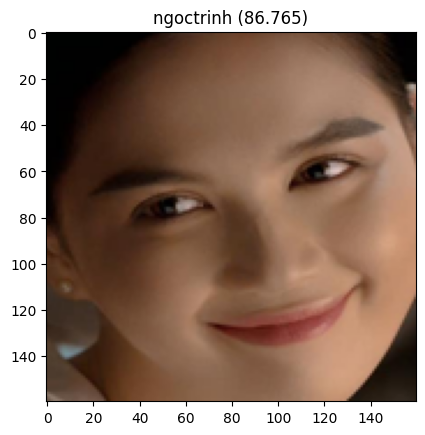

In [ ]:
from random import choice
# select a random face from test set
selection = choice([i for i in range(testX.shape[0])])
random_face = testX[selection]
random_face_emd = emdTestX_norm[selection]
random_face_class = testy_enc[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples = np.expand_dims(random_face_emd, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
all_names = out_encoder.inverse_transform([0,1,2,3,4,5,6])
#print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
print('Expected: %s' % random_face_name[0])
# plot face
plt.imshow(random_face)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()

In [ ]:
def get_single_face(img,bbox):
      x1, y1, width, height = bbox
      # deal with negative pixel index
      x1, y1 = abs(x1), abs(y1)
      x2, y2 = x1 + width, y1 + height
      # extract the face
      return img[y1:y2, x1:x2]

1/1 [==============================] - 0s 28ms/step


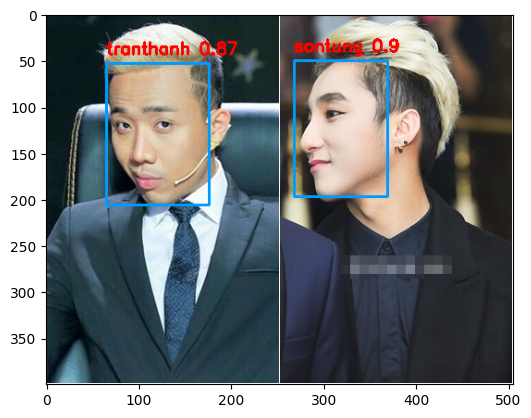

In [100]:
#predict oder image
from random import choice

# select a random face from test set
def predict_img(img_path):
  img = plt.imread(img_path)
  faces_bboxes = detector.detect_faces(img)
  for bbox in faces_bboxes:
    face = get_single_face(img,bbox['box'])
    x, y, width, height = bbox['box']
    face_emd = get_embedding(facenet_model,face)
    samples = np.expand_dims(face_emd, axis=0)
    yhat_class = model.predict(samples)
    yhat_prob = model.predict_proba(samples)
  # get name
    class_index = yhat_class[0]
    class_probability = yhat_prob[0,class_index] * 100
    predict_names = out_encoder.inverse_transform(yhat_class)
    all_names = out_encoder.inverse_transform([0,1,2,3,4,5,6])
    predicted  = 'unknow'
    if yhat_prob[0][yhat_prob[0].argmax()] > 0.6:
      prob  =  yhat_prob[0][yhat_prob[0].argmax()]
      predicted = all_names[yhat_prob[0].argmax()]+ ' ' + str(round(prob,2))
    img = cv2.rectangle(img, (x, y), (x+width, y+height), (0, 155, 255), 2)
    cv2.putText(
        img,
        predicted,
        (int(x), int(y) - 10),
        fontFace = cv2.FONT_HERSHEY_SIMPLEX,
        fontScale = 0.6,
        color = (255, 0, 0),
        thickness=2
    )
  return img

# random_face_emd = get_embedding(facenet_model,random_face)
plt.imshow(predict_img('/content/tran-thanh-bi-son-tung-nhap5.jpg'))